# Dataset: 
https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification

In [23]:
import os

def display_contents(path, indent=0):
    for root, dirs, files in os.walk(path):
        current_indent = ' ' * indent
        print(f"{current_indent}{root}")
        
        for file in files[:3]:
            print(f"{current_indent}  File: {file}")
        if len(files) > 3:
            print(f"{current_indent}  ... [ total : {len(files)}]")
        
        for directory in dirs:
            display_contents(os.path.join(root, directory), indent + 2)

def n_images(path):
    counter = 0
    for root, dirs, files in os.walk(path):
        for file in files[:3]:
            counter+=1  
        for directory in dirs:
            counter+=n_images(os.path.join(root, directory))
    return counter

dataset_path = "..\dataset"  # put the path to the dataset
# display_contents(dataset_path) # in case you want to see what the folder looks like
print("N of files (images):",n_images(dataset_path))


N of files (images): 1382


In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
import random

In [25]:
input_base_path = dataset_path # path for the dataset
training_folder = 'traffic_Data/DATA'
testing_folder = 'traffic_Data/TEST'
classes = pd.read_csv(os.path.join(input_base_path,'labels.csv'))
print("Total number of classes: ", len(classes))

Total number of classes:  58


In [26]:
from PIL import Image, ImageEnhance
import os

def augment_image(original_image: Image.Image):
    augmented = [original_image]
    for i in range(1, 5):
        augmented_image = original_image.copy()
        if i == 1:
            augmented_image = augmented_image.convert('RGB').quantize(colors=32)
        elif i == 2:
            enhancer = ImageEnhance.Brightness(augmented_image)
            augmented_image = enhancer.enhance(0.7)
        elif i == 3:
            augmented_image = augmented_image.rotate(25)
        elif i == 4:
            augmented_image = augmented_image.rotate(-25)
        augmented.append(augmented_image)
    return augmented

In [27]:
from tqdm import tqdm


traffic_data = []
training_data = []
labels = []
def fetch_images(traffic_data: list, labels: list, augment: bool = False) -> tuple[list, list]:
    for class_value in tqdm(os.listdir(os.path.join(input_base_path, training_folder))):
        class_path = os.path.join(input_base_path, training_folder, class_value)
        labels.append(class_value)
        for trafficSignal in os.listdir(class_path):
            img = Image.open(os.path.join(class_path,trafficSignal))
            if augment:
                for img in augment_image(img):
                    img = img.resize((90,90))
                    img = np.array(img)
                    traffic_data.append((img,[int(class_value)]))
            else:
                img = img.resize((90,90))
                img = np.array(img)
                traffic_data.append((img,[int(class_value)]))
    labels = np.array(labels)
    return traffic_data, labels

In [28]:
traffic_data, labels = fetch_images(traffic_data, labels)
traffic_data_features, traffic_data_labels = zip(*traffic_data)
training_data_features, validation_data_features, training_data_labels, validation_data_labels = train_test_split(traffic_data_features, traffic_data_labels, test_size=0.33, random_state=42)
training_data_features = np.array(training_data_features)
training_data_labels = np.array(training_data_labels)
validation_data_features = np.array(validation_data_features)
validation_data_labels = np.array(validation_data_labels)
print(training_data_features.shape)
print(training_data_labels.shape)

  0%|          | 0/58 [00:00<?, ?it/s]

100%|██████████| 58/58 [00:12<00:00,  4.79it/s]


(2793, 90, 90, 3)
(2793, 1)


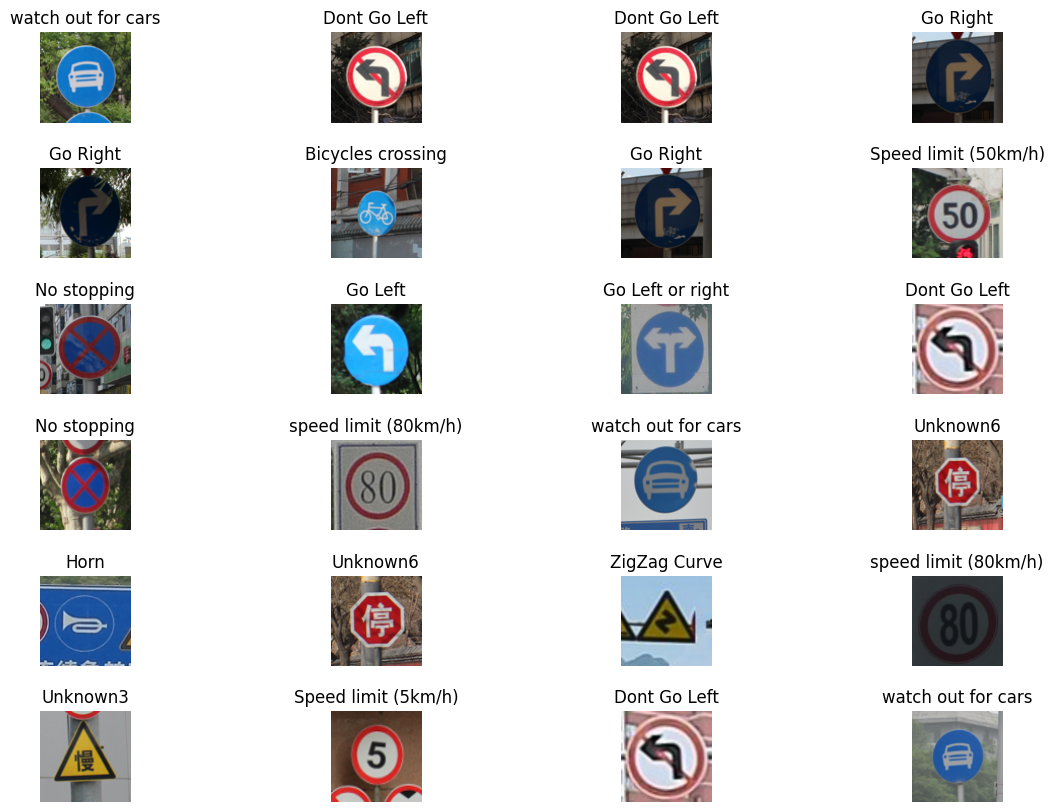

In [29]:
def img_displayer(data_features: list, data_labels_act: list, data_labels_pred: list = None):
    rows, cols = 6, 4
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    plt.subplots_adjust(wspace = 0, hspace = 0.5) 
    if data_labels_pred is not None:
        for row in range(rows):
            for col in range(cols):
                i = row * cols + col
                random_val = random.randint(1,2)
                display_image = data_features[i*random_val]
                display_label_act = classes['Name'][data_labels_act[i*random_val][0]]
                display_label_pred = classes['Name'][data_labels_pred[i*random_val]]

                axes[row, col].imshow(display_image, cmap='gray') 
                axes[row, col].set_title((display_label_act, display_label_pred))
                axes[row, col].axis('off')
    else:
        for row in range(rows):
            for col in range(cols):
                i = row * cols + col
                random_val = random.randint(1,2)
                display_image = data_features[i*random_val]
                display_label = classes['Name'][data_labels_act[i*random_val][0]]

                axes[row, col].imshow(display_image, cmap='gray') 
                axes[row, col].set_title(display_label)
                axes[row, col].axis('off')
img_displayer(training_data_features, training_data_labels)

In [30]:
def convolution_model() -> Sequential:
    cnn_model = Sequential()
    cnn_model.add(Conv2D(16, (3, 3), padding="same", input_shape=(90, 90, 3), activation='relu'))
    print(cnn_model(training_data_features).shape)
    cnn_model.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnn_model.add(Conv2D(32,(3,3), padding="same", activation='relu'))
    cnn_model.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnn_model.add(Conv2D(64,(5,5), padding="same", activation='relu'))
    cnn_model.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnn_model.add(Conv2D(128,(7,7), padding="same", activation='relu'))
    cnn_model.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(232, activation='relu'))
    cnn_model.add(Dense(116, activation='relu'))
    cnn_model.add(Dense(58, activation='softmax'))
    return cnn_model

In [31]:
## epochs = 12
epochs = 1
batch_size = 50
cnn_model = convolution_model()
cnn_model.summary()

(2793, 90, 90, 16)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 90, 90, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 23, 23, 64)        51264     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None,

In [32]:
print(training_data_features.shape, training_data_labels.shape)
print(training_data_labels)

(2793, 90, 90, 3) (2793, 1)
[[28]
 [54]
 [11]
 ...
 [ 5]
 [55]
 [17]]


In [33]:
cnn_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
traffic_sign_network = cnn_model.fit(training_data_features, training_data_labels, batch_size=batch_size, epochs=epochs, validation_data=(validation_data_features, validation_data_labels))

c:\Users\di-co\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 [==============================] - 27s 3s/step - loss: 47.3691 - accuracy: 0.0362 - val_loss: 4.2146 - val_accuracy: 0.0733


28/28 [==============================] - 21s 540ms/step - loss: 7.2157 - accuracy: 0.1489 - val_loss: 2.7863 - val_accuracy: 0.3203
Epoch 2/4
28/28 [==============================] - 14s 501ms/step - loss: 2.0947 - accuracy: 0.4697 - val_loss: 1.4180 - val_accuracy: 0.6594
Epoch 3/4
28/28 [==============================] - 13s 460ms/step - loss: 0.9999 - accuracy: 0.7433 - val_loss: 0.8886 - val_accuracy: 0.7603
Epoch 4/4
28/28 [==============================] - 13s 472ms/step - loss: 0.5400 - accuracy: 0.8532 - val_loss: 0.5324 - val_accuracy: 0.8540

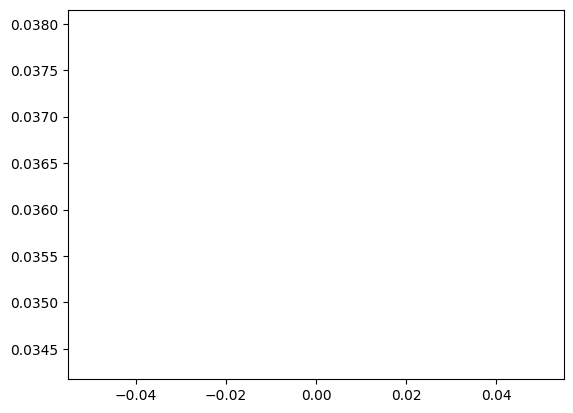

In [34]:
plt.plot(traffic_sign_network.history['accuracy'], label='accuracy')

In [35]:
# Evaluating the model on test data
testing_data = []
for test_image_file in os.listdir(os.path.join(input_base_path, testing_folder)):
    testImage = Image.open(os.path.join(input_base_path, testing_folder, test_image_file))
    testImage = testImage.resize((90,90))
    testImage = np.array(testImage)
    testing_data.append((testImage, [int(test_image_file[1:3])]))
testing_data_features, testing_data_labels = zip(*testing_data)
testing_data_features = np.array(testing_data_features)
testing_data_labels = np.array(testing_data_labels)

In [36]:
# Evaluate the test data
predictions = cnn_model.predict(testing_data_features)
predicted_labels = np.argmax(predictions, axis=1)

63/63 [==============================] - 5s 72ms/step


54    No stopping
54    No stopping
54    No stopping
54    No stopping
54    No stopping
         ...     
54    No stopping
54    No stopping
54    No stopping
54    No stopping
54    No stopping
Name: Name, Length: 1994, dtype: object
0     Speed limit (5km/h)
0     Speed limit (5km/h)
0     Speed limit (5km/h)
0     Speed limit (5km/h)
0     Speed limit (5km/h)
             ...         
56               Unknown7
57               Unknown8
57               Unknown8
57               Unknown8
57               Unknown8
Name: Name, Length: 1994, dtype: object


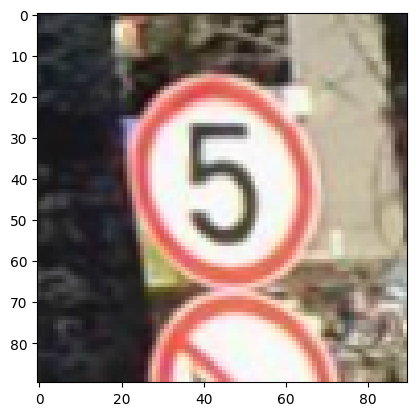

In [37]:
# Visualize Result Data and Actual Data
print(classes['Name'][predicted_labels])
print(classes['Name'][testing_data_labels[:,0]])
plt.imshow(testing_data_features[1])

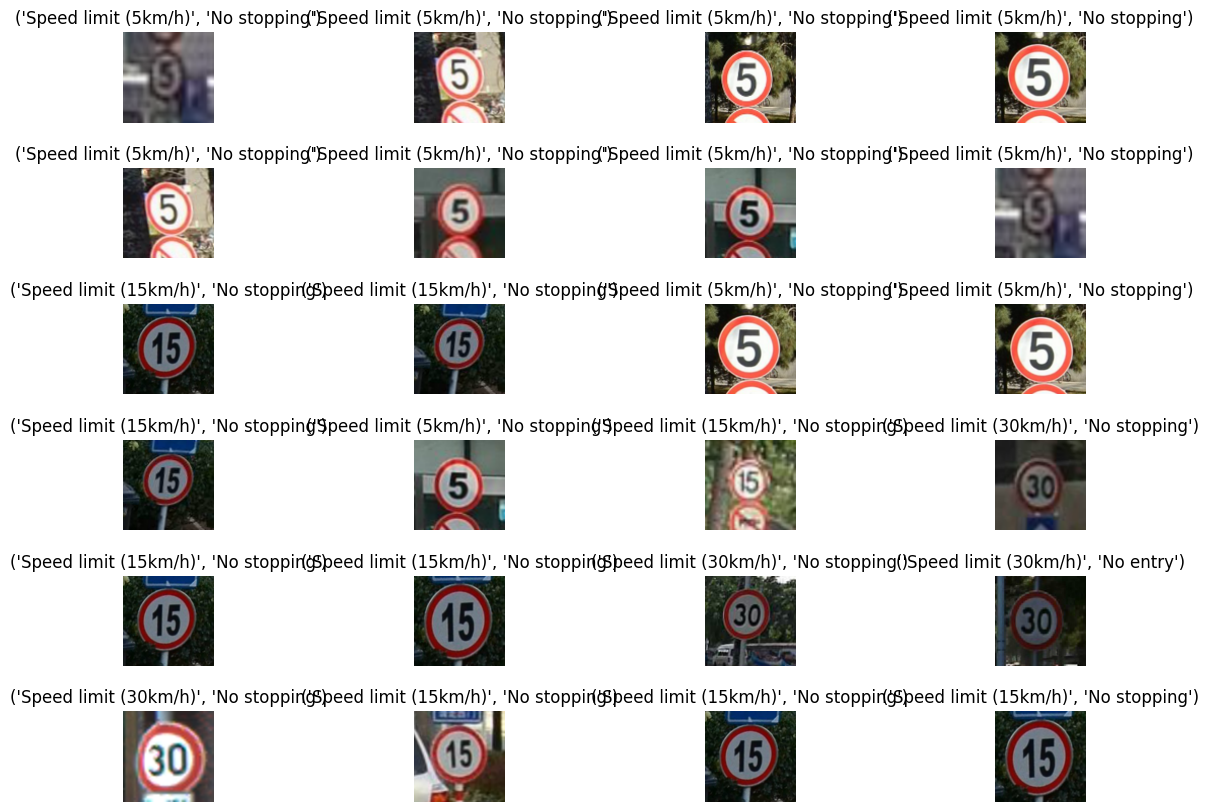

In [38]:
img_displayer(testing_data_features, testing_data_labels, predicted_labels)
# (Actual Label, Predicted Label)

In [39]:
test_loss, test_acc = cnn_model.evaluate(testing_data_features, testing_data_labels, verbose=2)
print(test_acc)

63/63 - 4s - loss: 4.3453 - accuracy: 0.0853 - 4s/epoch - 57ms/step
0.08525576442480087


In [40]:
from sklearn.metrics import classification_report

predictions = cnn_model.predict(testing_data_features)

predicted_labels = np.argmax(predictions, axis=1)

class_report_dict = classification_report(testing_data_labels, predicted_labels, output_dict=True)

class_accuracies = {classes['Name'][int(class_label)]+f" ({int(class_label)}) ": (report['precision'],report['recall']) for class_label, report in class_report_dict.items() if class_label.isnumeric()}

sorted_precisions = sorted(class_accuracies.items(), key=lambda x: x[1][0], reverse=True)

for class_label, accuracy in sorted_precisions:
    print(f"Accuracy of Class {class_label}: {accuracy}")

sorted_recalls = sorted(class_accuracies.items(), key=lambda x: x[1][1], reverse=True)

for class_label, accuracy in sorted_recalls:
    print(f"Accuracy of Class {class_label}: {accuracy}")


63/63 [==============================] - 4s 60ms/step
Accuracy of Class No stopping (54) : (0.09140369967355821, 0.9545454545454546)
Accuracy of Class No entry (55) : (0.02564102564102564, 0.034482758620689655)
Accuracy of Class Speed limit (5km/h) (0) : (0.0, 0.0)
Accuracy of Class Speed limit (15km/h) (1) : (0.0, 0.0)
Accuracy of Class Speed limit (30km/h) (2) : (0.0, 0.0)
Accuracy of Class Speed limit (40km/h) (3) : (0.0, 0.0)
Accuracy of Class Speed limit (50km/h) (4) : (0.0, 0.0)
Accuracy of Class Speed limit (60km/h) (5) : (0.0, 0.0)
Accuracy of Class Speed limit (70km/h) (6) : (0.0, 0.0)
Accuracy of Class speed limit (80km/h) (7) : (0.0, 0.0)
Accuracy of Class Dont Go straight or left (8) : (0.0, 0.0)
Accuracy of Class Dont Go straight (10) : (0.0, 0.0)
Accuracy of Class Dont Go Left (11) : (0.0, 0.0)
Accuracy of Class Dont Go Left or Right (12) : (0.0, 0.0)
Accuracy of Class Dont Go Right (13) : (0.0, 0.0)
Accuracy of Class Dont overtake from Left (14) : (0.0, 0.0)
Accuracy of 

c:\Users\di-co\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\di-co\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\di-co\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [41]:
import os
from PIL import Image

# Assuming you have a list of class names
class_names = classes['Name']

label_counts = {class_name: 0 for class_name in class_names}

for test_image_file in os.listdir(os.path.join(input_base_path, testing_folder)):
    label = int(test_image_file[1:3])
    class_name = classes['Name'][label]  # Assuming you have a dataframe named 'classes' with label names
    label_counts[class_name] += 1

# Print the counts
for class_name, count in label_counts.items():
    print(f"Label {class_name}: Number of images corresponding: {count}")


Label Speed limit (5km/h): Number of images corresponding: 14
Label Speed limit (15km/h): Number of images corresponding: 12
Label Speed limit (30km/h): Number of images corresponding: 60
Label Speed limit (40km/h): Number of images corresponding: 84
Label Speed limit (50km/h): Number of images corresponding: 58
Label Speed limit (60km/h): Number of images corresponding: 50
Label Speed limit (70km/h): Number of images corresponding: 30
Label speed limit (80km/h): Number of images corresponding: 50
Label Dont Go straight or left: Number of images corresponding: 14
Label Dont Go straight or Right: Number of images corresponding: 0
Label Dont Go straight: Number of images corresponding: 60
Label Dont Go Left: Number of images corresponding: 130
Label Dont Go Left or Right: Number of images corresponding: 22
Label Dont Go Right: Number of images corresponding: 92
Label Dont overtake from Left: Number of images corresponding: 12
Label No Uturn: Number of images corresponding: 36
Label No Ca

63/63 [==============================] - 4s 57ms/step


c:\Users\di-co\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\di-co\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\di-co\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

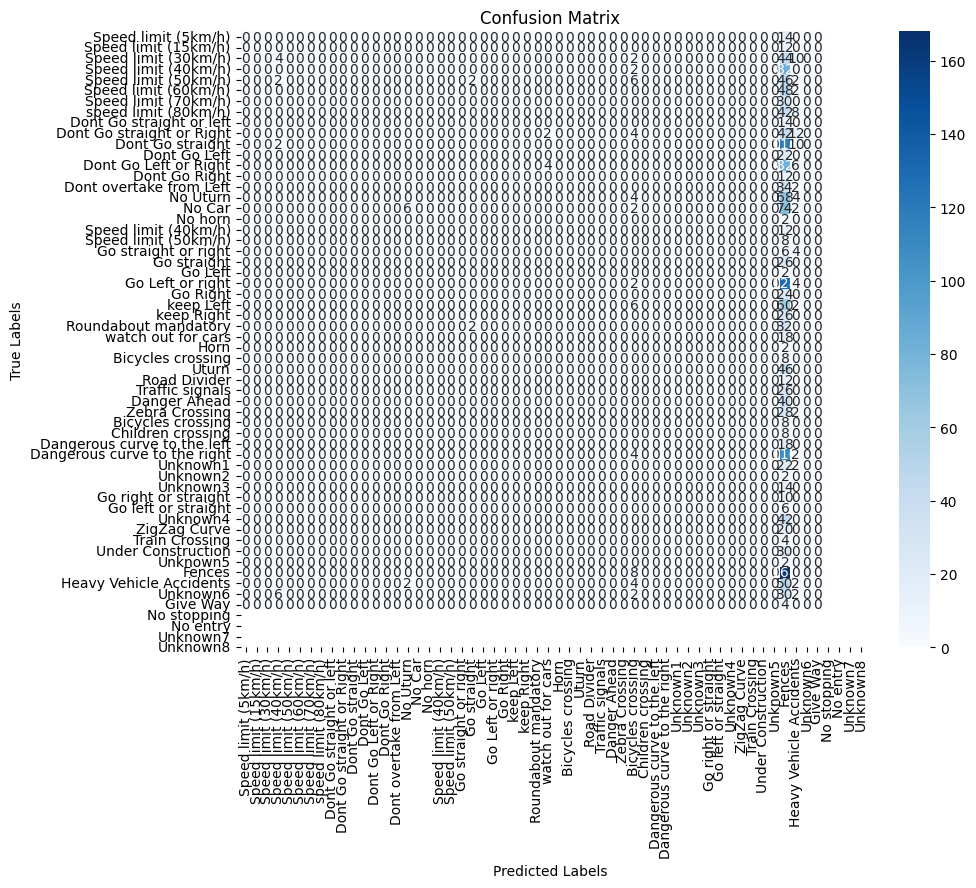

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = cnn_model.predict(testing_data_features)

predicted_labels = np.argmax(predictions, axis=1)

class_report_dict = classification_report(testing_data_labels, predicted_labels, output_dict=True)

class_accuracies = {classes['Name'][int(class_label)]: report['precision'] for class_label, report in class_report_dict.items() if class_label.isnumeric()}

sorted_accuracies = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)

# Create confusion matrix
conf_matrix = confusion_matrix(testing_data_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Let Analyse the challenges in this dataset

1. The data available is not equaly distributed among the classes. Thus leading to the biased models which is one of the most common problem in the world of machine learning.
2. There are some images without proper labeling but luckily there aren't images of mutiple types under single lable.
